### Airline Loyalty Analysis and Customer Churn Prediction
This is my personal project, giving an analysis of airline loyalty program. The dataset is available at https://maven-datasets.s3.amazonaws.com 

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#### Load the data tables

In [15]:
string_cols = ['Loyalty Number', 'Year', 'Month', 'Enrollment Year', 'Enrollment Month', 'Cancellation Year', 'Cancellation Month']
dtypes = {key:str for key in string_cols}
flight = pd.read_csv('../data/Customer Flight Activity.csv', dtype=dtypes)
loyalty = pd.read_csv('../data/Customer Loyalty History.csv', dtype=dtypes)

In [12]:
flight.head(2)

,Loyalty Number,Year,Month,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,100590,2018,6,12,15276,22914.0,0,0
1,100590,2018,7,12,9168,13752.0,0,0


In [13]:
loyalty.head(2)

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN


In [26]:
pd.concat([loyalty.isna().sum(),loyalty.isna().sum()/len(loyalty)], axis=1).reset_index()

,index,0,1
0,Loyalty Number,0,0.000000
1,Country,0,0.000000
2,Province,0,0.000000
3,City,0,0.000000
4,Postal Code,0,0.000000
5,Gender,0,0.000000
6,Education,0,0.000000
7,Salary,4238,0.253211
8,Marital Status,0,0.000000
9,Loyalty Card,0,0.000000


There is no null value in the flight activity table. However, in the customer loyalty history table, salary column has null percentage of 25%. Null value in cancellation columns indicating that customers still maintain their loyalty status.

We will use a KNN model to predict the salary of those missing

In [46]:
## Drop unnecessary columns
model_data = loyalty.set_index('Loyalty Number').drop(columns=['Cancellation Year', 'Cancellation Month', 'Postal Code', 'Country'])
model_data = model_data.loc[model_data['Salary'].notnull()]
object_cols = model_data.select_dtypes('object').columns
## Check nbr of unique values in each columns to apply suitable encoding techniques
nuni = model_data[object_cols].nunique()
nuni

Province            11
City                29
Gender               2
Education            4
Marital Status       3
Loyalty Card         3
Enrollment Type      2
Enrollment Year      7
Enrollment Month    12
dtype: int64

We will be using Label Encoding for features that has only 2 unique values, and Target Encoding for others

In [75]:
from sklearn.preprocessing import TargetEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
## Choosing columns with 2 unique values
l_encode = nuni.loc[nuni.values == 2].index
## label encoding
label_encoder = LabelEncoder() 
for col in  l_encode:
    model_data[col] = label_encoder.fit_transform(model_data[col]) 

 
# Split the data into features (X) and target (y)
X = model_data.drop('Salary', axis=1)
y = model_data['Salary']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
## target encoding  
target_encoder = TargetEncoder(target_type='continuous').set_output(transform='pandas')
target_encoder.fit(X_train[[col for col in nuni.index if col not in l_encode]], y_train)
x_train_encoded = target_encoder.transform(X_train[[col for col in nuni.index if col not in l_encode]])
x_test_encoded = target_encoder.transform(X_test[[col for col in nuni.index if col not in l_encode]])

for col in x_train_encoded.columns:
    X_train[col] = x_train_encoded[col]
    X_test[col] = x_test_encoded[col]
X_train

,Province,City,Gender,Education,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month
Loyalty Number,,,,,,,,,,
314014,80624.419330,77940.278996,0,72080.024925,78991.876293,82045.261826,2434.00,1,80520.564889,79605.963665
328602,80373.406938,79151.089396,0,72080.024925,78126.736960,76652.373458,36229.41,1,80408.858577,83591.691453
957061,80009.669056,81059.233345,0,72250.768994,79589.025407,76582.417098,5414.90,1,81818.250814,79188.478229
445839,80699.288575,79170.899605,0,73127.699855,78445.061749,80362.365095,3755.81,1,79641.421012,76906.786438
105063,80624.419330,82425.325520,1,181650.792112,83755.699001,82045.261826,7251.33,0,75424.165256,77696.051921
...,...,...,...,...,...,...,...,...,...,...
604822,76969.423309,76969.423309,1,72250.768994,79589.025407,79467.187999,3409.68,1,79199.433786,83260.376496
262508,80813.822763,81010.653477,1,72713.474989,79534.857155,80577.025944,5004.26,1,82156.954146,80594.083420
793619,79869.439101,78927.536780,0,73127.699855,78445.061749,79064.097151,9320.09,1,78245.223874,78368.607750


Build Model to predict salary

Text(0, 0.5, 'Error')

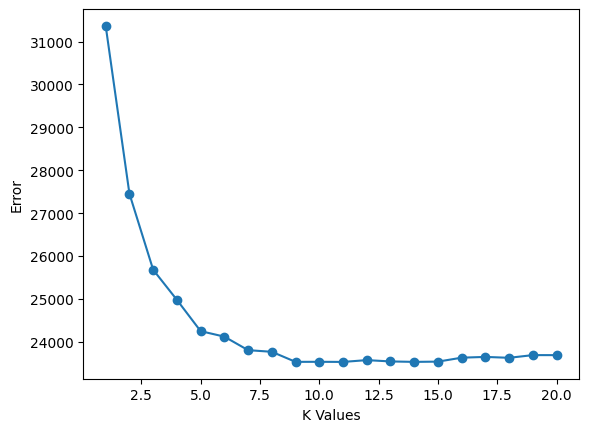

In [76]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

rmse_val = []
for k in range(1, 21):
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    error = sqrt(mean_squared_error(y_test, pred))
    rmse_val.append(error)

plt.plot(range(1, 21),rmse_val, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Error")

We will select k = 9, which is shown in the graph as a small k that achieve low error

In [81]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve
knn = KNeighborsRegressor(n_neighbors=9)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
df = pd.DataFrame({'y_test':y_test, 'y_pred':y_pred})
df['diff'] = (df['y_pred'] - df['y_test']).abs()
df['diff'].describe()

count      2500.000000
mean      17180.615467
std       16085.609626
min           2.555556
25%        6949.416667
50%       14568.611111
75%       22834.083333
max      146174.666667
Name: diff, dtype: float64

Predict missing salary info

In [ ]:
predict_data = loyalty.set_index('Loyalty Number').drop(columns=['Cancellation Year', 'Cancellation Month', 'Postal Code', 'Country'])
predict_data = model_data.loc[model_data['Salary'].notnull()]

##### Detailed Analysis

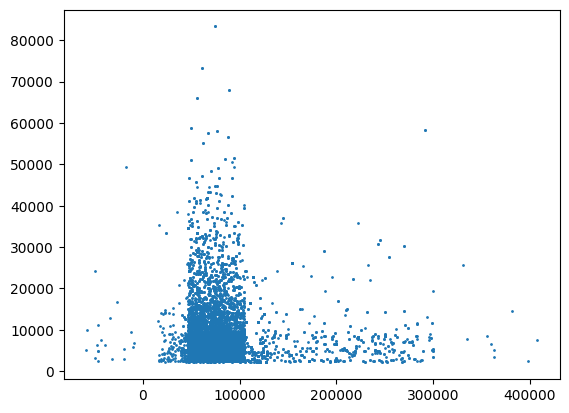

In [14]:
plt.scatter(x=loyalty['Salary'], y=loyalty['CLV'], s=1)

In [15]:
data = loyalty.merge(flight, on=['Loyalty Number'])
data

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,...,Enrollment Month,Cancellation Year,Cancellation Month,Year,Month,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,...,2,NaN,NaN,2018,7,5,11355,11355.0,0,0
1,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,...,2,NaN,NaN,2017,5,4,4908,4908.0,0,0
2,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,...,2,NaN,NaN,2017,6,4,6948,6948.0,0,0
3,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,...,2,NaN,NaN,2017,8,4,5516,5516.0,0,0
4,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,...,2,NaN,NaN,2018,4,4,4376,4376.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392931,652627,Canada,Manitoba,Winnipeg,R2C 0M5,Female,Bachelor,75049.0,Married,Star,...,12,2016.0,8.0,2018,8,0,0,0.0,0,0
392932,652627,Canada,Manitoba,Winnipeg,R2C 0M5,Female,Bachelor,75049.0,Married,Star,...,12,2016.0,8.0,2018,9,0,0,0.0,0,0
392933,652627,Canada,Manitoba,Winnipeg,R2C 0M5,Female,Bachelor,75049.0,Married,Star,...,12,2016.0,8.0,2018,10,0,0,0.0,0,0
392934,652627,Canada,Manitoba,Winnipeg,R2C 0M5,Female,Bachelor,75049.0,Married,Star,...,12,2016.0,8.0,2018,11,0,0,0.0,0,0
